In [2]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir
import uproot3
import uproot
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon,ThetaPQ ):## '__init__' is the constructor of the class
        self.virtual_photon = virtual_photon
        Nu = virtual_photon.E()   ##components of a 4-vector TLorentzVector
        Q2 = -virtual_photon.M2() ## magnitud squared of a 4-vector TLorentzVector
        self.proton = ROOT.TLorentzVector()  ## proton is an attribute of the class 'particle' just created.
        self.proton.SetPxPyPzE(0,0,0, 0.938)  ## SetPxPyPzE is just a function of ROOT
        self.W = (virtual_photon + self.proton).M() ##.M() return the magnitud of a TLorentzVector [W2=(p+q)2]
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect())) ## sign returns -1 0 or 1 if the input is negative, zero or positive.
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition, virtual photon
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        self.LorentzVector = fourvector #hadron four-vector. 4-vector is an input of this class
        self.PhiLab = self.LorentzVector.Phi()
        self.ThetaLab = self.LorentzVector.Theta()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star) # y is rapidity
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.P = np.sqrt(self.LorentzVector.Px()**2+self.LorentzVector.Py()**2+self.LorentzVector.Pz()**2)
      
    def redefine(self, new_virtual_photon):
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = new_virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = new_virtual_photon.Vect().Cross(self.LorentzVector.Vect()).Unit()
        sign  = np.sign(part1.Dot(self.LorentzVector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2)) 
        self.Pt = self.LorentzVector.Vect().Perp(new_virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.LorentzVector.Vect().Dot(new_virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.virtual_photon = new_virtual_photon
        
        return
        
    def print_properties(self):
        print ('Hello, let me introduce myself, i am particle pid = ' , self.pid, ' with index ', self.index, ', from event  #', self.ievt, ' Nu and W', self.Nu, ' ' , self.W)
        print ('zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y)
        print ('pid = ' , self.pid)       
        
    

In [72]:
def getDataframes(filename, Target=1,maxevents=1e9,tree_name='ntuple_data',isMC=False):
    dphi = np.array([])  
    include_truth=isMC
    ParticlesFromPrevious = []
    
    try:
        myfile = TFile.Open('%s'%filename,'READ')
        myfile.Print()
    except:
        print("could not open file")
    mytree = myfile.Get(tree_name)
        
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    
    tupla = {}  
    tupla['dphi'] = [] 
    tupla['dphi_lab'] = []
    tupla['drap'] = []
    tupla['h1_z'] = [] 
    tupla['h2_z'] = []
    tupla['h1_cm_pt'] = []
    tupla['h2_cm_pt'] = []
    tupla['h1_xf'] = []
    tupla['h2_xf'] = []
    tupla['h1_rap'] = []
    tupla['ycm'] = []
    tupla['h2_rap'] = []
    tupla['h1_pid'] = []
    tupla['h2_pid'] = []
    tupla['h1_cm_ph'] = []
    tupla['h2_cm_ph'] = []
    tupla['h1_cm_th'] = []  
    tupla['h2_cm_th'] = []  
    tupla['pair_mass'] = []
    tupla['pair_pt'] = []
    tupla['mx_eh1h2x'] = []
    tupla['mx_eh1x'] = []
    tupla['mx_eh2x'] = []
    tupla['t']  = []
    tupla['Q2'] = [] 
    tupla['nu'] = []
    tupla['W']  = []
    tupla['SampFracEl25'] = []
    tupla['SampFracEl20'] = []
    tupla['TargTypeSM'] = [] ## RD's vertex cuts
    tupla['TargType'] = []   ## Taisiya's vertex cuts (nominal)
    tupla['x'] = [] ## bjorken x
    tupla['u']  = []
    tupla['h1_ph'] = []
    tupla['h1_th'] = []
    tupla['h2_ph'] = []
    tupla['h2_th'] = []
    tupla['h1_deltaZ'] = []
    tupla['h2_deltaZ'] = []
    tupla['h1_Nphe'] = []
    tupla['h2_Nphe'] = []
    tupla['h1_Sector'] = []
    tupla['h2_Sector'] = []
    tupla['h1_FidCut'] = []
    tupla['h2_FidCut'] = []
    tupla['h1_FidCutPiPlus'] = []
    tupla['h2_FidCutPiPlus'] = []
    tupla['h1_Chi2CC'] = []
    tupla['h2_Chi2CC'] = []
    tupla['h1_StatCC'] = []
    tupla['h2_StatCC'] = []
    tupla['h1_Betta'] = []
    tupla['h2_Betta'] = []
    tupla['h1_T4'] = []
    tupla['h2_T4'] = []    
    tupla['evnt']  = []

    #mc truth variables (added by Sebouh)
    if include_truth:
        tupla['dphi_truth'] = [] 
        tupla['dphi_lab_truth'] = []
        tupla['drap_truth'] = []
        tupla['h1_truth_z'] = [] 
        tupla['h2_truth_z'] = []
        tupla['h1_truth_cm_pt'] = []
        tupla['h2_truth_cm_pt'] = []
        tupla['h1_truth_xf'] = []
        tupla['h2_truth_xf'] = []
        tupla['h1_truth_rap'] = []
        tupla['ycm_truth'] = []
        tupla['h2_truth_rap'] = []
        tupla['h1_truth_pid'] = []
        tupla['h2_truth_pid'] = []
        tupla['h1_truth_cm_ph'] = []
        tupla['h2_truth_cm_ph'] = []
        tupla['h1_truth_cm_th'] = []  
        tupla['h2_truth_cm_th'] = []  
        tupla['pair_mass_truth'] = []
        tupla['pair_pt_truth'] = []
        tupla['mx_eh1h2x_truth'] = []
        tupla['mx_eh1x_truth'] = []
        tupla['mx_eh2x_truth'] = []
        tupla['t_truth']  = []
        tupla['Q2_truth'] = [] 
        tupla['nu_truth'] = []
        tupla['W_truth']  = []
        tupla['x_truth'] = []
        tupla['u_truth']  = []
        tupla['h1_truth_ph'] = []
        tupla['h1_truth_th'] = []
        tupla['h2_truth_ph'] = []
        tupla['h2_truth_th'] = []    
    
    ## here we create another dictionary
    tupla_mix = {}
    tupla_mix['dphi'] = []
    tupla_mix['dphi_lab'] = []
    tupla_mix['drap'] = []
    tupla_mix['h1_z'] = []
    tupla_mix['h2_z'] = []
    tupla_mix['h1_cm_pt'] = []
    tupla_mix['h2_cm_pt'] = []
    tupla_mix['h1_xf'] = []
    tupla_mix['h2_xf'] = []
    tupla_mix['h1_rap'] = []
    tupla_mix['ycm'] = []
    tupla_mix['h2_rap'] = []
    tupla_mix['h1_pid'] = []
    tupla_mix['h2_pid'] = []
    tupla_mix['h1_cm_ph']   = []
    tupla_mix['h2_cm_ph'] = []
    tupla_mix['h1_cm_th'] = []
    tupla_mix['h2_cm_th'] = []
    tupla_mix['pair_mass'] = []
    tupla_mix['pair_pt'] = []
    tupla_mix['mx_eh1h2x'] = []
    tupla_mix['mx_eh1x'] = []
    tupla_mix['mx_eh2x'] = []
    tupla_mix['t']  = []
    tupla_mix['Q2'] = []
    tupla_mix['nu'] = []
    tupla_mix['W']  = []
    tupla_mix['SampFracEl25'] = []
    tupla_mix['SampFracEl20'] = []
    tupla_mix['TargTypeSM'] = [] ## RD's vertex cuts
    tupla_mix['TargType'] = []   ## Taisiya's vertex cuts (nominal)
    tupla_mix['x'] = []
    tupla_mix['u']  = []
    tupla_mix['h1_ph'] = []
    tupla_mix['h1_th'] = []
    tupla_mix['h2_ph'] = []
    tupla_mix['h2_th'] = []
    tupla_mix['dphi_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_ph_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_th_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h1_deltaZ'] = []
    tupla_mix['h2_deltaZ'] = []
    tupla_mix['h1_Nphe'] = []
    tupla_mix['h2_Nphe'] = []
    tupla_mix['h1_Sector'] = []
    tupla_mix['h2_Sector'] = []
    tupla_mix['h1_FidCut'] = []
    tupla_mix['h2_FidCut'] = []    
    tupla_mix['h1_FidCutPiPlus'] = []
    tupla_mix['h2_FidCutPiPlus'] = []       
    tupla_mix['h1_Chi2CC'] = []
    tupla_mix['h2_Chi2CC'] = []
    tupla_mix['h1_StatCC'] = []
    tupla_mix['h2_StatCC'] = []
    tupla_mix['evnt'] = []
    
    ## here we create another dictionary
    tupla_trigger = {}
    tupla_trigger['h1_pid'] = []
    tupla_trigger['h1_xf'] = []
    tupla_trigger['h1_xf_default'] = []
    tupla_trigger['h1_z']  = []
    tupla_trigger['h1_cm_pt'] = []
    tupla_trigger['h1_rap']  = []
    tupla_trigger['ycm'] = []
    tupla_trigger['Q2'] = []
    tupla_trigger['x'] = []
    tupla_trigger['nu'] = []
    tupla_trigger['W'] = []
    tupla_trigger['SampFracEl25'] = []
    tupla_trigger['SampFracEl20'] = []
    tupla_trigger['TargTypeSM'] = [] ## RD's vertex cuts
    tupla_trigger['TargType'] = []   ## Taisiya's vertex cuts (nominal)
    tupla_trigger['h1_cm_ph'] = []
    tupla_trigger['h1_cm_th'] = []
    tupla_trigger['TargType'] = []
    tupla_trigger['missing_mass'] = []
    tupla_trigger['h1_ph'] = []
    tupla_trigger['h1_th'] = []
    tupla_trigger['h1_deltaZ'] = []
    tupla_trigger['h1_Nphe'] = []
    tupla_trigger['h1_Sector'] = []
    tupla_trigger['h1_FidCut'] = []
    tupla_trigger['h1_FidCutPiPlus'] = []
    tupla_trigger['h1_Chi2CC'] = []
    tupla_trigger['h1_StatCC'] = []
    tupla_trigger['evnt'] = []
    #if include_truth:
    if False:
        tupla_trigger['h1_truth_pid'] = []
        tupla_trigger['h1_truth_xf'] = []
        tupla_trigger['h1_truth_xf_default'] = []
        tupla_trigger['h1_truth_z'] = []
        tupla_trigger['h1_truth_cm_pt'] = []
        tupla_trigger['h1_truth_rap'] = []
        tupla_trigger['ycm_truth'] = []
        tupla_trigger['h1_truth_cm_ph'] = []
        tupla_trigger['h1_truth_cm_th'] = []
        tupla_trigger['missing_mass_truth'] = []
        tupla_trigger['Q2_truth'] = []
        tupla_trigger['x_truth'] = []
        tupla_trigger['nu_truth'] = []
        tupla_trigger['h1_truth_ph'] = []
        tupla_trigger['h1_truth_th'] = []
        tupla_trigger['h1_truth_Sector'] = []
        tupla_trigger['evnt_truth'] = []
        tupla_trigger['W_truth'] = []                
 
    if include_truth:
        mytree.mc_W = 0.938**2+mytree.mc_Nu*0.938*2-mytree.mc_Q2
        
    
    start = time.time()
    print('About to loop over ', mytree.GetEntries() , ' entries')
    for ievt  in range(mytree.GetEntries()):
        #if len(mytree.FidCheckCut) != len(mytree.Sector):
        #    print('This shouldn\'t ever happen: len(mytree.FidCheckCut) != len(mytree.Sector). Skipping event')
        #    continue
            
        mytree.GetEntry(ievt)   
        if mytree.W<2.0 or mytree.Q2<1.0: continue

        if ievt>maxevents: break        
        if(mytree.TargTypeHH==1):
            TargType=1
        elif(mytree.TargTypeHH==2):
            TargType=2
        else:
            TargType=0
        #print (TargType,  ' ' , Target)
        #if not(isMC) and (TargType!=Target): continue ## 'Target' is a argument of this function
                
        #print('PASO all cuts')
        W = mytree.W
        Nu = mytree.Nu
        #get electron momentum:
        Pe = np.sqrt(mytree.Pex*mytree.Pex + mytree.Pey*mytree.Pey+ mytree.Pez*mytree.Pez)
        scattered_e = ROOT.TLorentzVector()
        scattered_e.SetPxPyPzE(mytree.Pex, mytree.Pey, mytree.Pez, Pe)
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        virtual_photon  = incoming_e - scattered_e 
        virtual_photon_unitvector = virtual_photon.Vect().Unit()
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        
        
        if include_truth:
            Nu_truth = mytree.mc_Nu
            Pe_truth = np.sqrt(mytree.mc_Pex*mytree.mc_Pex + mytree.mc_Pey*mytree.mc_Pey+ mytree.mc_Pez*mytree.mc_Pez)
            scattered_e_truth = ROOT.TLorentzVector()
            scattered_e_truth.SetPxPyPzE(mytree.mc_Pex, mytree.mc_Pey, mytree.mc_Pez, Pe_truth)
            virtual_photon_truth  = incoming_e - scattered_e_truth 
            virtual_photon_unitvector_truth = virtual_photon_truth.Vect().Unit()
            proton_truth = ROOT.TLorentzVector()
            proton_truth.SetPxPyPzE(0,0,0, 0.938)
        
        ## for each event the particles are saved in the 'particles' list.        
        particles = []  
        particles_truth = []
        for i in range(len(mytree.pid)):
            if (abs(mytree.pid[i]) !=211 and mytree.pid[i]!=2212): continue 
            #print( len(mytree.FidCheckCut) ,'!=',len(mytree.Sector) ) 
            #print ('ievt: ', ievt)
            
            if len(mytree.FidCheckCut) != len(mytree.Sector):
                print('This shouldn\'t ever happen: len(mytree.FidCheckCut) != len(mytree.Sector). Skipping event')
                continue                
                
                
                
            i_lv = ROOT.TLorentzVector()    ## 4-vector of the hadron
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.Zh[i]*Nu) 
            if include_truth:
                i_lv_truth = ROOT.TLorentzVector()    ## 4-vector of the hadron
                i_lv_truth.SetPxPyPzE(mytree.mc_Px[i],mytree.mc_Py[i],mytree.mc_Pz[i],mytree.mc_Zh[i]*Nu_truth) 
                i_part_truth = particle(mytree.mc_pid[i], i_lv_truth, virtual_photon_truth, mytree.mc_ThetaPQ[i] )
           
            
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i] ) 
            particles.append(i_part)   ## save that particle in the 'particles' list
            X = (virtual_photon + proton -  i_part.LorentzVector) #unobserved hadronic system
            
            #if include_truth:
            #    particles_truth.append(i_part_truth)
            #    X_truth = (virtual_photon_truth + proton_truth -  i_part_truth.LorentzVector) #unobserved hadronic system
            
            if i_part.Zh > 0.5: 
                tupla_trigger['h1_pid'].append(i_part.pid)
                tupla_trigger['h1_xf'].append(i_part.Xf)
                tupla_trigger['h1_xf_default'].append(-1)
                tupla_trigger['h1_z'].append(i_part.Zh)
                tupla_trigger['h1_cm_pt'].append(i_part.Pt)
                tupla_trigger['h1_rap'].append(i_part.y_star)
                tupla_trigger['ycm'].append(i_part.ycm)
                tupla_trigger['h1_cm_ph'].append(i_part.PhiPQ)
                tupla_trigger['h1_cm_th'].append(i_part.ThetaPQ)
                tupla_trigger['missing_mass'].append(X.M())
                tupla_trigger['Q2'].append(mytree.Q2)
                tupla_trigger['x'].append(mytree.Xb)
                tupla_trigger['nu'].append(mytree.Nu)
                tupla_trigger['W'].append(mytree.W)
                tupla_trigger['SampFracEl25'].append(mytree.SampFractionEl25)
                tupla_trigger['SampFracEl20'].append(mytree.SampFractionEl20)
                tupla_trigger['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                tupla_trigger['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                tupla_trigger['h1_ph'].append(mytree.PhiLab[i])
                tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                tupla_trigger['h1_deltaZ'].append(mytree.deltaZ[i])
                tupla_trigger['h1_Nphe'].append(mytree.Nphe[i])
                tupla_trigger['h1_Sector'].append(mytree.Sector[i])
                tupla_trigger['h1_FidCut'].append(mytree.FidCheckCut[i])
                tupla_trigger['h1_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[i])
                tupla_trigger['h1_Chi2CC'].append(mytree.Chi2CC[i])
                tupla_trigger['h1_StatCC'].append(mytree.StatCC[i])
                tupla_trigger['evnt'].append(mytree.evnt)
                
                #if include_truth:
                if False:
                    if i_part_truth.Zh > 0.5: 
                        tupla_trigger['h1_truth_pid'].append(i_part_truth.pid)
                        tupla_trigger['h1_truth_xf'].append(i_part_truth.Xf)
                        tupla_trigger['h1_truth_xf_default'].append(-1)
                        tupla_trigger['h1_truth_z'].append(i_part_truth.Zh)
                        tupla_trigger['h1_truth_cm_pt'].append(i_part_truth.Pt)
                        tupla_trigger['h1_truth_rap'].append(i_part_truth.y_star)
                        tupla_trigger['ycm_truth'].append(i_part_truth.ycm)
                        tupla_trigger['h1_truth_cm_ph'].append(i_part_truth.PhiPQ)
                        tupla_trigger['h1_truth_cm_th'].append(i_part_truth.ThetaPQ)
                        tupla_trigger['missing_mass_truth'].append(X_truth.M())
                        tupla_trigger['Q2_truth'].append(mytree.mc_Q2)
                        tupla_trigger['x_truth'].append(mytree.mc_Xb)
                        tupla_trigger['nu_truth'].append(mytree.mc_Nu)
                        tupla_trigger['h1_truth_ph'].append(mytree.mc_PhiLab[i])
                        tupla_trigger['h1_truth_th'].append(mytree.mc_ThetaLab[i])#i_part.LorentzVector.Theta())
                        tupla_trigger['h1_truth_Sector'].append(mytree.mc_Sector[i])
                        tupla_trigger['evnt_truth'].append(mytree.evnt)
                        tupla_trigger['W_truth'].append(mytree.mc_W)
                #print('ojoooo',len(mytree.pid) )
                for j in range(len(mytree.pid)): 
                    if i==j: continue
                    if (abs(mytree.pid[j]) !=211 and mytree.pid[j]!=2212): continue
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.Zh[j]*Nu)
                    j_part = particle(mytree.pid[j], j_lv, virtual_photon, mytree.ThetaPQ[j] )
                    ## particle is the defined class
                    if include_truth:
                        j_lv_truth = ROOT.TLorentzVector()    ## 4-vector of the hadron
                        j_lv_truth.SetPxPyPzE(mytree.mc_Px[j],mytree.mc_Py[j],mytree.mc_Pz[j],mytree.mc_Zh[j]*Nu_truth) ## this is the 4-vector of the hadron
                        j_part_truth = particle(mytree.mc_pid[j], j_lv_truth, virtual_photon_truth, mytree.mc_ThetaPQ[j] ) ## particle is the class defined previously
                        dphi_truth = abs(ROOT.TVector2.Phi_mpi_pi(i_part_truth.PhiPQ-j_part_truth.PhiPQ))  
                        dphi_lab_truth = abs(ROOT.TVector2.Phi_mpi_pi(i_part_truth.PhiLab-j_part_truth.PhiLab))
                        dy_truth = i_part_truth.y-j_part_truth.y
                        deta_truth = dy_truth
                        
                        dihadron_truth = i_part_truth.LorentzVector+j_part_truth.LorentzVector  ## LorentzVector is a method of the 
                                    #particle class, is the '4-vector' of the particle, 3rd argument of the class
                    
                        X_truth  = (virtual_photon_truth + proton - dihadron_truth) #unobserved hadronic system
                        X1_truth = (virtual_photon_truth + proton - i_part_truth.LorentzVector)
                        X2_truth = (virtual_photon_truth + proton - j_part_truth.LorentzVector)

                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))  
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))
                    dy = i_part.y-j_part.y  
                    deta = dy
                    ## Di-hadron 4-vector, is the sum P_{di-hadron} = P_{trigger-hadron} + P_{other-hadron}
                    dipion = i_part.LorentzVector+j_part.LorentzVector                     
                    X  = (virtual_photon + proton - dipion) #unobserved hadronic system
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - j_part.LorentzVector)
                    
                    ## note: drap is h1_rap - h2_rap
                    tupla['dphi'].append(dphi) ## phiPQ(i) - phiPQ(j)
                    tupla['dphi_lab'].append(dphi_lab)
                    tupla['drap'].append(dy)         ## This is in lab frame -> dy = y_lab(i) - y_lab(j)
                    tupla['h1_z'].append(i_part.Zh)
                    tupla['h2_z'].append(j_part.Zh)
                    tupla['h1_cm_pt'].append(i_part.Pt)
                    tupla['h2_cm_pt'].append(j_part.Pt)
                    tupla['h1_xf'].append(i_part.Xf)
                    tupla['h2_xf'].append(j_part.Xf)
                    tupla['h1_rap'].append(i_part.y_star)  ## y_star = y(lab) - y(cm)
                    tupla['ycm'].append(i_part.ycm)
                    tupla['h2_rap'].append(j_part.y_star)
                    tupla['h1_pid'].append(i_part.pid)
                    tupla['h2_pid'].append(j_part.pid)
                    tupla['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla['h2_cm_ph'].append(j_part.PhiPQ)
                    tupla['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla['h2_cm_th'].append(j_part.ThetaPQ)
                    tupla['pair_mass'].append(dipion.M())
                    tupla['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla['mx_eh1h2x'].append(X.M())
                    tupla['mx_eh1x'].append(X1.M())
                    tupla['mx_eh2x'].append(X2.M())
                    tupla['t'].append( -(virtual_photon- dipion).M2())
                    tupla['Q2'].append(mytree.Q2)
                    tupla['x'].append(mytree.Xb)
                    tupla['nu'].append(mytree.Nu)
                    tupla['W'].append(mytree.W)
                    tupla['SampFracEl25'].append(mytree.SampFractionEl25)
                    tupla['SampFracEl20'].append(mytree.SampFractionEl20)
                    tupla['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                    tupla['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                    tupla['u'].append(-(scattered_e-proton).M2())
                    tupla['h1_ph'].append(mytree.PhiLab[i])
                    tupla['h1_th'].append(mytree.ThetaLab[i])
                    tupla['h2_ph'].append(mytree.PhiLab[j])
                    tupla['h2_th'].append(mytree.ThetaLab[j])
                    tupla['h1_deltaZ'].append(mytree.deltaZ[i])
                    tupla['h2_deltaZ'].append(mytree.deltaZ[j])
                    tupla['h1_Nphe'].append(mytree.Nphe[i])
                    tupla['h1_Sector'].append(mytree.Sector[i])
                    
                    if(len(mytree.FidCheckCut )==len(mytree.Sector )):
                        tupla['h1_FidCut'].append(mytree.FidCheckCut[i])
                    else:
                        print('this should never happen:  len(mytree.FidCheckCut)!=len(mytree.FidCheckCutPiPlus)')                    
                    tupla['h1_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[i])
                    tupla['h2_Nphe'].append(mytree.Nphe[j])
                    tupla['h2_Sector'].append(mytree.Sector[j])
                    #tupla['h1_FidCut'].append(mytree.FidCheckCut[i])
                    tupla['h2_FidCut'].append(mytree.FidCheckCut[j]) 
                    tupla['h2_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[j])                    
                    tupla['h1_Chi2CC'].append(mytree.Chi2CC[i])
                    tupla['h1_StatCC'].append(mytree.StatCC[i])
                    tupla['h2_Chi2CC'].append(mytree.Chi2CC[j])
                    tupla['h2_StatCC'].append(mytree.StatCC[j])
                    tupla['h1_Betta'].append(mytree.Betta[i])
                    tupla['h2_Betta'].append(mytree.Betta[j])
                    tupla['h1_T4'].append(mytree.T4[i])
                    tupla['h2_T4'].append(mytree.T4[j])
                    tupla['evnt'].append(mytree.evnt)

                    
                    if include_truth:
                        tupla['dphi_truth'].append(dphi_truth)
                        tupla['dphi_lab_truth'].append(dphi_lab_truth)
                        tupla['drap_truth'].append(dy_truth)
                        tupla['h1_truth_z'].append(i_part_truth.Zh)
                        tupla['h2_truth_z'].append(j_part_truth.Zh)
                        tupla['h1_truth_cm_pt'].append(i_part_truth.Pt)
                        tupla['h2_truth_cm_pt'].append(j_part_truth.Pt)
                        tupla['h1_truth_xf'].append(i_part_truth.Xf)
                        tupla['h2_truth_xf'].append(j_part_truth.Xf)
                        tupla['h1_truth_rap'].append(i_part_truth.y_star)
                        tupla['ycm_truth'].append(i_part_truth.ycm)
                        tupla['h2_truth_rap'].append(j_part_truth.y_star)
                        tupla['h1_truth_pid'].append(i_part_truth.pid)
                        tupla['h2_truth_pid'].append(j_part_truth.pid)
                        tupla['h1_truth_cm_ph'].append(i_part_truth.PhiPQ)
                        tupla['h2_truth_cm_ph'].append(j_part_truth.PhiPQ)
                        tupla['h1_truth_cm_th'].append(i_part_truth.ThetaPQ)
                        tupla['h2_truth_cm_th'].append(j_part_truth.ThetaPQ)
                        tupla['pair_mass_truth'].append(dihadron_truth.M())
                        tupla['pair_pt_truth'].append( dihadron_truth.Vect().Perp(virtual_photon_unitvector_truth))
                        tupla['mx_eh1h2x_truth'].append(X_truth.M())
                        tupla['mx_eh1x_truth'].append(X1_truth.M())
                        tupla['mx_eh2x_truth'].append(X2_truth.M())
                        tupla['t_truth'].append( -(virtual_photon_truth- dihadron_truth).M2())
                        tupla['Q2_truth'].append(mytree.mc_Q2)
                        tupla['x_truth'].append(mytree.mc_Xb)
                        tupla['nu_truth'].append(mytree.mc_Nu)
                        tupla['W_truth'].append(mytree.mc_W)
                        tupla['u_truth'].append(-(scattered_e_truth-proton).M2())
                        tupla['h1_truth_ph'].append(mytree.mc_PhiLab[i])
                        tupla['h1_truth_th'].append(mytree.mc_ThetaLab[i])
                        tupla['h2_truth_ph'].append(mytree.mc_PhiLab[j])
                        tupla['h2_truth_th'].append(mytree.mc_ThetaLab[j])
                                            
         #end loop over secondary loop    
                
                ## here we are still under the condition of Zh>0.4
                #print(ievt,i,j)
                #print('')
                for mixparticle in ParticlesFromPrevious: ## ParticlesFromPrevious is a list 
                                                          ## with 'particle' class objects
                    #print('\ninside mixparticle loop\n')
                    #print('i: ',i,'mixparticles pid:',mixparticle.pid,' zh :', mixparticle.Zh , ', W: ', 
                           #mixparticle.W, ' i_part Zh:', i_part.Zh, 'i_part.W: ',i_part.W)
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)
                    tupla_mix['h2_cm_ph_norot'].append(mixparticle.PhiPQ)
                    tupla_mix['h2_cm_th_norot'].append(mixparticle.ThetaPQ)

                    mixparticle.redefine(virtual_photon) 
                    #recalculates variables in this' event photon frame (not in the previous one)
                    #dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    #print 'dphi_pq after redefinition: ', dphi , ' phi_pq ', mixparticle.PhiPQ
                    
                    dipion = i_part.LorentzVector+mixparticle.LorentzVector
                    X  = (virtual_photon + proton - dipion)
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - mixparticle.LorentzVector)

                    #recalculate the phi_pq. It has to be with respect to the photon direction
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-mixparticle.PhiLab))

                    dy = i_part.y-mixparticle.y
                    deta = dy#i_part.ThetaPQ-mixparticle.ThetaPQ
                    tupla_mix['dphi'].append(dphi)
                    tupla_mix['dphi_lab'].append(dphi_lab)
                    tupla_mix['drap'].append(dy)
                    tupla_mix['h1_z'].append(i_part.Zh)
                    tupla_mix['h2_z'].append(mixparticle.Zh)
                    tupla_mix['h1_cm_pt'].append(i_part.Pt)
                    tupla_mix['h2_cm_pt'].append(mixparticle.Pt)
                    tupla_mix['h1_xf'].append(i_part.Xf)
                    tupla_mix['h2_xf'].append(mixparticle.Xf)
                    tupla_mix['h1_rap'].append(i_part.y_star)
                    tupla_mix['ycm'].append(i_part.ycm)
                    tupla_mix['h2_rap'].append(mixparticle.y_star)
                    tupla_mix['h1_pid'].append(i_part.pid)
                    tupla_mix['h2_pid'].append(mixparticle.pid)
                    tupla_mix['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla_mix['h2_cm_ph'].append(mixparticle.PhiPQ)
                    tupla_mix['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla_mix['h2_cm_th'].append(mixparticle.ThetaPQ)
                    tupla_mix['pair_mass'].append(dipion.M())
                    tupla_mix['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla_mix['mx_eh1h2x'].append(X.M())
                    tupla_mix['mx_eh1x'].append(X1.M())
                    tupla_mix['mx_eh2x'].append(X2.M())
                    tupla_mix['t'].append( -(virtual_photon- dipion).M2())
                    tupla_mix['Q2'].append(mytree.Q2)
                    tupla_mix['x'].append(mytree.Xb)
                    tupla_mix['nu'].append(mytree.Nu)
                    tupla_mix['W'].append(mytree.W)
                    tupla_mix['SampFracEl25'].append(mytree.SampFractionEl25)
                    tupla_mix['SampFracEl20'].append(mytree.SampFractionEl20)
                    tupla_mix['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                    tupla_mix['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                    tupla_mix['u'].append(-(scattered_e-proton).M2())
                    tupla_mix['h1_ph'].append(i_part.LorentzVector.Phi())
                    tupla_mix['h1_th'].append(mytree.ThetaLab[i])
                    tupla_mix['h2_ph'].append(mixparticle.LorentzVector.Phi())
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
                    tupla_mix['h1_deltaZ'].append(mytree.deltaZ[i])
                    tupla_mix['h2_deltaZ'].append(mytree.deltaZ[j])
                    tupla_mix['h1_Nphe'].append(mytree.Nphe[i])
                    tupla_mix['h1_Sector'].append(mytree.Sector[i])
                    tupla_mix['h1_FidCut'].append(mytree.FidCheckCut[i])
                    tupla_mix['h1_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[i])
                    tupla_mix['h2_Nphe'].append(mytree.Nphe[j])
                    tupla_mix['h2_Sector'].append(mytree.Sector[j])
                    tupla_mix['h2_FidCut'].append(mytree.FidCheckCut[j])
                    tupla_mix['h2_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[j])
                    tupla_mix['h1_Chi2CC'].append(mytree.Chi2CC[i])
                    tupla_mix['h1_StatCC'].append(mytree.StatCC[i])
                    tupla_mix['h2_Chi2CC'].append(mytree.Chi2CC[j])
                    tupla_mix['h2_StatCC'].append(mytree.StatCC[j])
                    tupla_mix['evnt'].append(mytree.evnt)
                    #for kk  in range (len(ParticlesFromPrevious)):
                        #print('ParticlesFromPrevious, pid:', ParticlesFromPrevious[kk].pid, 'zh: ', 
                               #ParticlesFromPrevious[kk].Zh, 'W: ',ParticlesFromPrevious[kk].W )
        #print (' Exiting main loop over particles (i loop, not over all entries)')
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    ##printing the 3 tuples to the output file
    df = pd.DataFrame(tupla)
    df_mix= pd.DataFrame(tupla_mix)
    df_trigger = pd.DataFrame(tupla_trigger)
    #print ('Number of triggers with z>0.4,  ', df.query('h1_z>0.4').shape[0])
    #print ('Number of pairs with z>0.4, '    , df_trigger.query('h1_z>0.4').shape[0]) 
    myfile.Close()
    return df, df_mix, df_trigger        
        

In [79]:
## here we defined some dictionaries ({})
df = {}
df_mc = {}
#path = '/home/seba/di-hadron/simul/Pb/'
path='/home/seba/di-hadron/simul/test_simul/'
#path = '/home/seba/di-hadron/simul/'
Files = listdir(path) 
tar='D2'
df_mc[tar],df_mc['%s_mix'%tar], df_mc['%s_trigger'%tar] = [None,None,None]
count =0
for name in Files:
    print('done with: ', count, ' files')
    count=count+1
    if( '%s'%tar not in name): continue
    
    filename = path+name
    print(filename)
    pairs, pairs_mix, trigger = getDataframes(filename,tree_name='ntuple_sim',Target=2,isMC=True)
    df_mc[tar] = pd.concat([ df_mc[tar], pairs])
    df_mc['%s_mix'%tar] = pd.concat([ df_mc['%s_mix'%tar], pairs_mix])
    df_mc['%s_trigger'%tar] = pd.concat([ df_mc['%s_trigger'%tar], trigger])

    print('Entries in the dataframe so far are ', df_mc[tar].shape[0])
    print('Entries in the MIXED dataframe so far are ', df_mc['%s_mix'%tar].shape[0])
    print('Entries in the trigger dataframe so far are ', df_mc['%s_trigger'%tar].shape[0])


done with:  0  files
done with:  1  files
done with:  2  files
/home/seba/di-hadron/simul/test_simul/D2_3.root
/home/seba/di-hadron/simul/test_simul/D2_3.root  has  8100000  entries
About to loop over  8100000  entries


<ipython-input-2-b4a67b038703>:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 635.80939245224 seconds
Entries in the dataframe so far are  132741
Entries in the MIXED dataframe so far are  262519
Entries in the trigger dataframe so far are  414919
done with:  3  files
done with:  4  files
/home/seba/di-hadron/simul/test_simul/D2_2.root
/home/seba/di-hadron/simul/test_simul/D2_2.root  has  8100000  entries
About to loop over  8100000  entries
Processed in 631.6512389183044 seconds
Entries in the dataframe so far are  265396
Entries in the MIXED dataframe so far are  525163
Entries in the trigger dataframe so far are  831624
done with:  5  files
/home/seba/di-hadron/simul/test_simul/D2_1.root
/home/seba/di-hadron/simul/test_simul/D2_1.root  has  8160000  entries
About to loop over  8160000  entries
Processed in 629.5352020263672 seconds
Entries in the dataframe so far are  397919
Entries in the MIXED dataframe so far are  788504
Entries in the trigger dataframe so far are  1249132
TFile: name=/home/seba/di-hadron/simul/test_simul/D2_3.root, title=, op

Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN


In [ ]:
df['C'].query('h2_z>0.2').hist(figsize=(20,20),bins=100,
                                      column=['h1_cm_pt','dphi_lab','dphi','h1_ph','h2_ph',
                                              'h1_cm_ph','h2_cm_ph','h2_pid'])
#plt.savefig('plot_test2.png', bbox_inches='tight')
plt.show()


In [ ]:
df_mc['D'].hist(figsize=(20,20),bins=100)
plt.show()

# Saving the MC file

In [80]:
%%notify
tar='D'
tar2='D2'
outName='MD_test_Pairs_%s.root'%tar

def to_root(df,filename, treename):
    with uproot3.recreate(filename) as f:
        f[treename] = uproot3.newtree({col:df[col].dtype for col in df.columns})
        f[treename].extend(dict(df))

to_root(df_mc[tar2]        ,'tmp_%s.root'%tar        ,'%s'%tar )
to_root(df_mc['%s_mix'%tar2]    ,'tmp_%s_mix.root'%tar    ,'%s_mix'%tar )
to_root(df_mc['%s_trigger'%tar2],'tmp_%s_trigger.root'%tar,'%s_trigger'%tar)

! hadd -f $outName tmp_*.root
! rm tmp_*.root


hadd Target file: MD_test_Pairs_D.root
hadd compression setting for all output: 1
hadd Source file 1: tmp_D.root
hadd Source file 2: tmp_D_mix.root
hadd Source file 3: tmp_D_trigger.root
hadd Target path: MD_test_Pairs_D.root:/


<IPython.core.display.Javascript object>

In [ ]:
## this is equivalent to: D_Fe->Draw("h1_ph>>h(100,0,1)"), ok!
plt.hist(df_mc['C']['h1_ph'],bins=100,range=(0,1.0))
df['D_Fe'].shape[0]  ## shape[0] return the number of rows of the array (number electrons)



In [ ]:
for target in ['Pb']:
    to_root(df_mc['%s'%target],'MC_Pairs_%s.root'%target, key='%s'%target)
    to_root(df_mc['%s_mix'%target],'MC_Pairs_%s.root'%target, key='%s_mix'%target,mode='a')
    to_root(df_mc['%s_trigger'%target],'MC_Pairs_%s.root'%target, key='%s_trigger'%target, mode='a')

In [ ]:
for kk in range(5):
    print('inside the loop',kk)
print('outside the loop',kk)    

In [ ]:
    for ievt  in range(mytree.GetEntries()):
        mytree.GetEntry(ievt)   
        particles = []  ## this is how you define a list in python, this is created for each event
        for i in range(len(mytree.pid)):
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i], mytree.Nphe[i], mytree.deltaZ[i], mytree.FidCheckCutPiPlus[i])     
            particles.append(i_part)
            if i_part.Zh > 0.4: #only save triggers and do correlations if they have z>0.4
                #tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                #for j in range(len(mytree.pid)): 
                #    if i==j: continue
                #    tupla['dphi'].append(dphi)
                #print(ievt,i,j)
                for mixparticle in ParticlesFromPrevious:
                    print('inside mixparticle loop')
                    #print(i,mixparticle, ParticlesFromPrevious)
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)

                    mixparticle.redefine(virtual_photon) #recalculates variables in this' event photon frame (not in the previous one)
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
        #print (' Exiting main loop over particles (i loop, not over all entries)')
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    return df, df_mix, df_trigger        
        
        
        

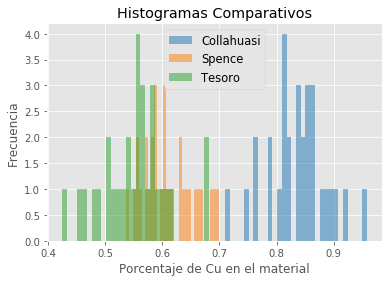

In [5]:
Collahuasi = [0.79,0.762,0.958,0.858,0.849,0.898,0.71,0.789,0.821,0.81,0.865,0.863,0.822,0.857,0.847,0.812,0.851,0.801,0.84,0.745,0.834,0.908,0.814,0.811,0.918,0.762,0.836,0.864,0.877,0.889]
Spence = [0.609,0.616,0.556,0.658,0.649,0.63,0.556,0.699,0.604,0.684,0.599,0.638,0.604,0.59,0.55,0.666,0.589,0.692,0.574,0.582,0.629,0.602,0.64,0.58,0.671,0.587,0.584,0.572,0.563,0.537]
Tesoro = [0.591,0.502,0.677,0.579,0.584,0.564,0.554,0.616,0.598,0.543,0.504,0.569,0.54,0.523,0.456,0.561,0.493,0.513,0.554,0.612,0.577,0.534,0.583,0.425,0.57,0.484,0.465,0.681,0.549,0.558]


plt.hist(Collahuasi, bins =30, label='Collahuasi',stacked=True,lw=4, fill=True, alpha=0.5, color='#1f77b4')
plt.hist(Spence, bins =30, label='Spence',stacked=True,lw=4, fill=True,color ='#ff7f0e', alpha=0.5 )
plt.hist(Tesoro, bins =30, label='Tesoro',stacked=True,lw=4, fill=True,color='#2ca02c', alpha=0.5)
plt.style.use('ggplot')
plt.xlabel('Porcentaje de Cu en el material')
plt.ylabel('Frecuencia')
plt.title('Histogramas Comparativos')
plt.legend(loc='best',frameon=True,fontsize=11.5,ncol=1 )
plt.savefig('proba.pdf', bbox_inches='tight')
plt.show()



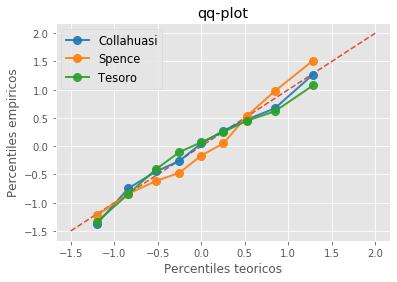

In [6]:
p_C = np.array([-1.37663,-0.748044,-0.447826,-0.260189,0.0494109,0.274575,0.471593,0.668611,1.26905 ])
p_S = np.array([-1.22577,-0.842247,-0.616645,-0.470004,-0.165441,0.0488804,0.533925,0.973848,1.51529])
p_T = np.array([-1.34248,-0.848583,-0.406673,-0.103401,0.0698969,0.25186,0.451153,0.615786,1.07503 ])
x=np.array([-1.2,-0.84,-0.52,-0.25,0,0.255,0.525,0.845,1.285])

plt.errorbar(x, p_C,label='Collahuasi', fmt='-o',ms=8, color='#1f77b4', alpha=0.9,lw=2)
plt.errorbar(x, p_S,label='Spence', fmt='-o',ms=8, color='#ff7f0e', alpha=0.9,lw=2)
plt.errorbar(x, p_T,label='Tesoro', fmt='-o',ms=8, color='#2ca02c', alpha=0.9,lw=2)
#plt.axhline(y=1.0,color='black',linestyle='--')
plt.plot([-1.5,2.0],[-1.5,2.0],linestyle='--')
plt.xlabel('Percentiles teoricos')
plt.ylabel('Percentiles empiricos')
plt.title('qq-plot')
plt.legend(loc='best',frameon=True,fontsize=11.5,ncol=1 )
plt.savefig('proba2.pdf', bbox_inches='tight')
plt.show()





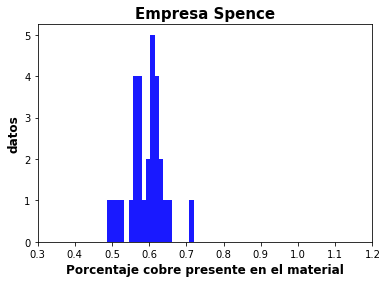

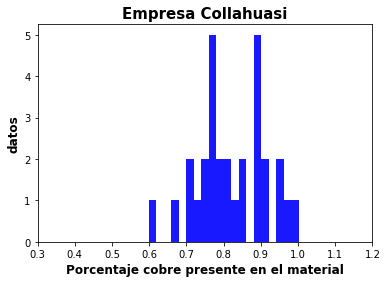

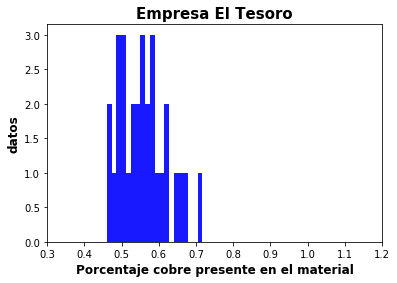

In [21]:
Collahuasi = [0.675,0.783,0.599,0.813,0.768,0.703,0.896,0.882,0.902,0.741,0.846,0.975,0.83,0.752,0.945,0.847,0.806,0.886,0.718,0.884,0.777,0.781,1.002,0.949,0.884,0.767,0.761,0.731,0.907,0.771]
Spence = [0.625,0.573,0.599,0.486,0.577,0.516,0.627,0.601,0.551,0.524,0.617,0.585,0.609,0.562,0.565,0.608,0.567,0.571,0.72,0.504,0.603,0.605,0.563,0.62,0.65,0.635,0.613,0.569,0.617,0.639]
Tesoro = [0.717,0.626,0.533,0.518,0.56,0.495,0.605,0.627,0.654,0.583,0.539,0.594,0.573,0.482,0.498,0.49,0.499,0.555,0.556,0.563,0.461,0.583,0.669,0.532,0.643,0.54,0.46,0.501,0.577,0.503]

plt.hist(Spence, bins =20, label='Spence',stacked=True,lw=4, fill=True,color ='blue', alpha=0.9 )
#plt.hist(Collahuasi, bins =20, label='Collahuasi',stacked=True,lw=4, fill=True, alpha=0.6, color='blue')
#plt.hist(Tesoro, bins =20, label='El Tesoro',stacked=True,lw=4, fill=True,color='magenta', alpha=0.6)
#plt.style.use('ggplot')
plt.xlabel('Porcentaje cobre presente en el material', fontweight='bold', fontsize=12)
plt.ylabel('datos', fontweight='bold', fontsize=12)
plt.xlim(0.3,1.2)
plt.title('Empresa Spence', fontweight='bold', fontsize=15)
#plt.legend(loc='best',frameon=False,fontsize=11.5,ncol=1 )
plt.savefig('proba_histo1.pdf', bbox_inches='tight')
plt.show()

#plt.hist(Spence, bins =20, label='Spence',stacked=True,lw=4, fill=True,color ='blue', alpha=0.9 )
plt.hist(Collahuasi, bins =20, label='Collahuasi',stacked=True,lw=4, fill=True, alpha=0.9, color='blue')
#plt.hist(Tesoro, bins =20, label='El Tesoro',stacked=True,lw=4, fill=True,color='magenta', alpha=0.6)
#plt.style.use('ggplot')
plt.xlabel('Porcentaje cobre presente en el material', fontweight='bold', fontsize=12)
plt.ylabel('datos', fontweight='bold', fontsize=12)
plt.xlim(0.3,1.2)
plt.title('Empresa Collahuasi', fontweight='bold', fontsize=15)
#plt.legend(loc='best',frameon=False,fontsize=11.5,ncol=1 )
plt.savefig('proba_histo2.pdf', bbox_inches='tight')
plt.show()

#plt.hist(Spence, bins =20, label='Spence',stacked=True,lw=4, fill=True,color ='blue', alpha=0.9 )
#plt.hist(Collahuasi, bins =20, label='Collahuasi',stacked=True,lw=4, fill=True, alpha=0.9, color='blue')
plt.hist(Tesoro, bins =20, label='El Tesoro',stacked=True,lw=4, fill=True,color='blue', alpha=0.9)
#plt.style.use('ggplot')
plt.xlabel('Porcentaje cobre presente en el material', fontweight='bold', fontsize=12)
plt.ylabel('datos', fontweight='bold', fontsize=12)
plt.xlim(0.3,1.2)
plt.title('Empresa El Tesoro', fontweight='bold', fontsize=15)
#plt.legend(loc='best',frameon=False,fontsize=11.5,ncol=1 )
plt.savefig('proba_histo3.pdf', bbox_inches='tight')
plt.show()



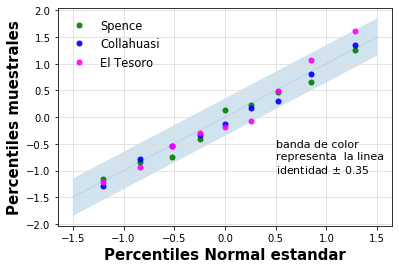

In [3]:
p_C = np.array([-1.29525,-0.785548,-0.545686,-0.343303,-0.125928,0.1739,0.301327,0.811034,1.35822 ])
p_S = np.array([-1.1513,-0.841863,-0.753453,-0.414546,0.130651,0.219061,0.469557,0.661113,1.25052])
p_T = np.array([-1.21947,-0.940145,-0.547579,-0.306,-0.19276,-0.0719705,0.494231,1.06043,1.60398 ])
x=np.array([-1.2,-0.84,-0.52,-0.25,0,0.255,0.525,0.845,1.285])

plt.errorbar(x, p_S,label='Spence', fmt='o',ms=5, color='green', alpha=0.9,lw=2)
plt.errorbar(x, p_C,label='Collahuasi', fmt='o',ms=5, color='blue', alpha=0.9,lw=2)
plt.errorbar(x, p_T,label='El Tesoro', fmt='o',ms=5, color='magenta', alpha=0.9,lw=2)
#plt.axhline(y=1.0,color='black',linestyle='--')
plt.plot([-1.5,1.5],[-1.5,1.5],linestyle='-', alpha=0.1)
#plt.plot([-1.5,2.0*1.5],[-1.5,2.0*1.5],linestyle='--')
#plt.plot([-1.5,2.0],[-1.5,2.0],linestyle='--')

y=np.array([-1.5, -1.0, -0.5,0,0.5,1.0,1.5])
plt.fill_between(y, y-0.35  ,y+0.35 ,label='',alpha=0.2,lw=5)
plt.grid(axis='both', color='gainsboro')
plt.xlabel('Percentiles Normal estandar', fontsize=15, fontweight='bold')
plt.ylabel('Percentiles muestrales', fontsize=15, fontweight='bold')
#plt.title('qq-plot', fontsize=20, fontweight='bold')
plt.legend(loc='best',frameon=False,fontsize=11.5,ncol=1 )
plt.text(0.5, -0.75, 'banda de color \nrepresenta  la linea \nidentidad $\pm$ 0.35', fontsize=11, va='center')

plt.savefig('proba_histo2.pdf', bbox_inches='tight')

plt.show()



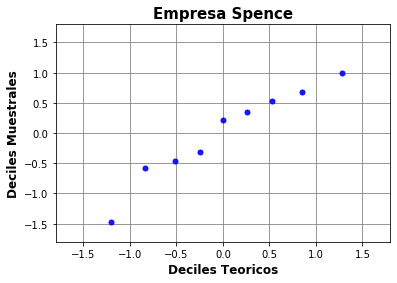

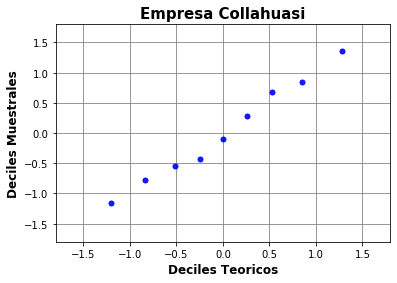

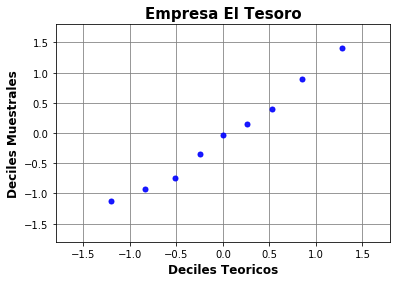

In [36]:
p_C = np.array([ -1.15759,-0.774801,-0.551505,-0.429224,-0.104914,0.288512,0.687255,0.846752,1.35714 ])
p_S = np.array([-1.47694,-0.580654,-0.464664,-0.31704,0.210188,0.347268,0.526525,0.684694,0.990486  ])
p_T = np.array([ -1.12127,-0.926243,-0.739018,-0.341165,-0.0369249,0.158101,0.392132,0.899199,1.41407])
x=np.array([-1.2,-0.84,-0.52,-0.25,0,0.255,0.525,0.845,1.285])




plt.errorbar(x, p_S,label='Spence', fmt='o',ms=5, color='blue', alpha=0.9,lw=2)
#plt.errorbar(x, p_C,label='Collahuasi', fmt='o',ms=5, color='blue', alpha=0.9,lw=2)
#plt.errorbar(x, p_T,label='El Tesoro', fmt='o',ms=5, color='magenta', alpha=0.9,lw=2)
#plt.axhline(y=1.0,color='black',linestyle='--')
#plt.plot([-1.5,1.5],[-1.5,1.5],linestyle='-', alpha=0.1)
#plt.plot([-1.5,2.0*1.5],[-1.5,2.0*1.5],linestyle='--')
#plt.plot([-1.5,2.0],[-1.5,2.0],linestyle='--')

#y=np.array([-1.5, -1.0, -0.5,0,0.5,1.0,1.5])
#plt.fill_between(y, y-0.35  ,y+0.35 ,label='',alpha=0.2,lw=5)
plt.grid(axis='both', color='grey')
plt.xlabel('Deciles Teoricos', fontsize=12, fontweight='bold')
plt.ylabel('Deciles Muestrales', fontsize=12, fontweight='bold')
plt.title('Empresa Spence', fontsize=15, fontweight='bold')
#plt.legend(loc='best',frameon=False,fontsize=11.5,ncol=1 )
#plt.text(0.5, -0.75, 'banda de color \nrepresenta  la linea \nidentidad $\pm$ 0.35', fontsize=11, va='center')
plt.xlim(-1.8,1.8)
plt.ylim(-1.8,1.8)
plt.savefig('qqplot_1.pdf', bbox_inches='tight')
plt.savefig('qqplot_1.png', bbox_inches='tight')

plt.show()





plt.errorbar(x, p_C,label='Collahuasi', fmt='o',ms=5, color='blue', alpha=0.9,lw=2)
#plt.errorbar(x, p_T,label='El Tesoro', fmt='o',ms=5, color='magenta', alpha=0.9,lw=2)
#plt.axhline(y=1.0,color='black',linestyle='--')
#plt.plot([-1.5,1.5],[-1.5,1.5],linestyle='-', alpha=0.1)
#plt.plot([-1.5,2.0*1.5],[-1.5,2.0*1.5],linestyle='--')
#plt.plot([-1.5,2.0],[-1.5,2.0],linestyle='--')

#y=np.array([-1.5, -1.0, -0.5,0,0.5,1.0,1.5])
#plt.fill_between(y, y-0.35  ,y+0.35 ,label='',alpha=0.2,lw=5)
plt.grid(axis='both', color='grey')
plt.xlabel('Deciles Teoricos', fontsize=12, fontweight='bold')
plt.ylabel('Deciles Muestrales', fontsize=12, fontweight='bold')
plt.title('Empresa Collahuasi', fontsize=15, fontweight='bold')
#plt.legend(loc='best',frameon=False,fontsize=11.5,ncol=1 )
#plt.text(0.5, -0.75, 'banda de color \nrepresenta  la linea \nidentidad $\pm$ 0.35', fontsize=11, va='center')
plt.xlim(-1.8,1.8)
plt.ylim(-1.8,1.8)
plt.savefig('qqplot_2.pdf', bbox_inches='tight')
plt.savefig('qqplot_2.png', bbox_inches='tight')
plt.show()


plt.errorbar(x, p_T,label='El Tesoro', fmt='o',ms=5, color='blue', alpha=0.9,lw=2)
#plt.axhline(y=1.0,color='black',linestyle='--')
#plt.plot([-1.5,1.5],[-1.5,1.5],linestyle='-', alpha=0.1)
#plt.plot([-1.5,2.0*1.5],[-1.5,2.0*1.5],linestyle='--')
#plt.plot([-1.5,2.0],[-1.5,2.0],linestyle='--')

#y=np.array([-1.5, -1.0, -0.5,0,0.5,1.0,1.5])
#plt.fill_between(y, y-0.35  ,y+0.35 ,label='',alpha=0.2,lw=5)
plt.grid(axis='both', color='grey')
plt.xlabel('Deciles Teoricos', fontsize=12, fontweight='bold')
plt.ylabel('Deciles Muestrales', fontsize=12, fontweight='bold')
plt.title('Empresa El Tesoro', fontsize=15, fontweight='bold')
#plt.legend(loc='best',frameon=False,fontsize=11.5,ncol=1 )
#plt.text(0.5, -0.75, 'banda de color \nrepresenta  la linea \nidentidad $\pm$ 0.35', fontsize=11, va='center')
plt.xlim(-1.8,1.8)
plt.ylim(-1.8,1.8)
plt.savefig('proba_histo2.pdf', bbox_inches='tight')
plt.savefig('qqplot_3.pdf', bbox_inches='tight')
plt.savefig('qqplot_3.png', bbox_inches='tight')
plt.show()
